In [282]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from itertools import combinations

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [283]:
# leer csv1 limpio
df1 = pd.read_csv("Files/Customer Flight Activity_limpio.csv")
df1.sample()

,Unnamed: 0,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
14241,14241,856364,2017,1,1,1,2,2300,230.0,0,0


In [284]:
# leer csv2 limpio
df2 = pd.read_csv("Files/Customer Loyalty History_limpio.csv")
df2.sample()

,numero_cliente,pais,provincia,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion,estado_cliente
15100,710255,Canada,British Columbia,Whistler,V6T 1Y8,Male,High School or Below,52477.0,Married,Star,8467.27,Standard,2016,1,2099,12,Activo


In [285]:
# leer csv unido
df = pd.read_csv("Files/datos_limpio_unidos.csv")
df.sample()

,Unnamed: 0,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados,pais,provincia,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion,estado_cliente
49660,49660,945014,2017,3,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P2T 6G3,Male,Bachelor,95061.0,Married,Aurora,4984.62,Standard,2017,7,2099,12,Activo


## 1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

In [286]:
# generamos columna fecha pasamos el año y mes 
df1['ano'] = df1['ano']
df1['mes'] = df1['mes']
# le damos valor 1 a todos los dias
df1['dia'] = 1

# Crear la columna de fecha combinando año, mes y día
df1['fecha'] = pd.to_datetime(df1[['ano', 'mes', 'dia']].rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}))

# Verifica el resultado
print(df1[['ano', 'mes', 'dia', 'fecha']].head())

    ano  mes  dia      fecha
0  2017    1    1 2017-01-01
1  2017    1    1 2017-01-01
2  2017    1    1 2017-01-01
3  2017    1    1 2017-01-01
4  2017    1    1 2017-01-01


Text(0, 0.5, 'Total de Vuelos')

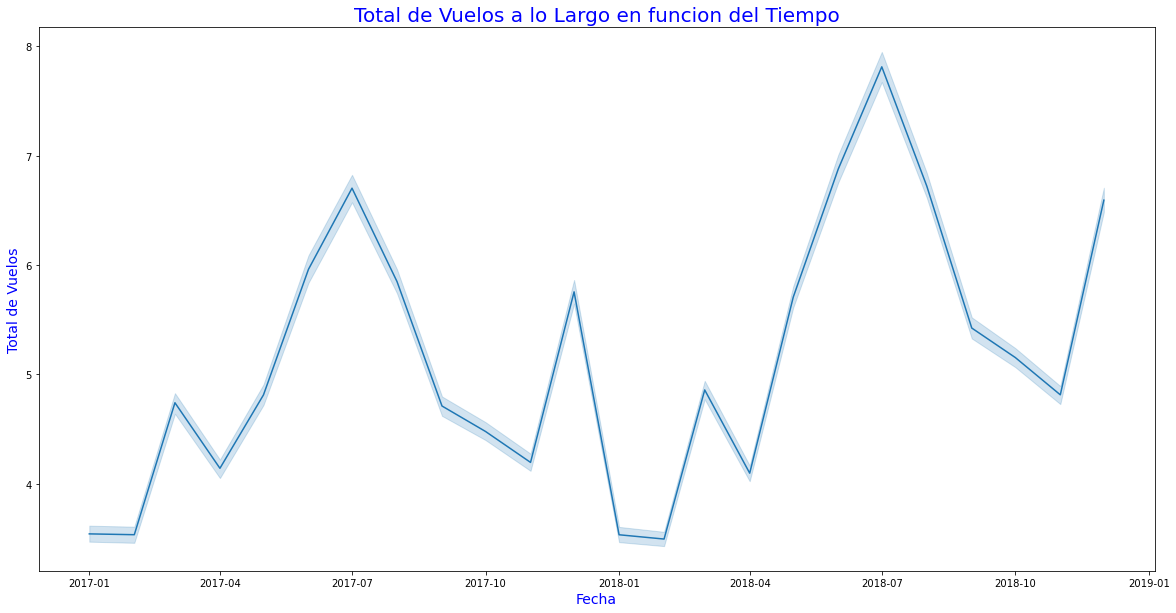

In [287]:
# tamano grafica 
plt.figure(figsize=(20,10))
# grafico de linea
sns.lineplot(data=df1, x="fecha", y="total_vuelos");

# Añadir un título al gráfico
plt.title('Total de Vuelos a lo Largo en funcion del Tiempo',color = "blue", fontsize=20)
# Nombrar el eje x
plt.xlabel('Fecha', fontsize=14, color='blue')

# Nombrar el eje y
plt.ylabel('Total de Vuelos', fontsize=14, color='blue')

En esta gráfica vemos que los meses donde hay mas reservas en es verano y navidad. teniendo el pico mas alto (en ambos años) en julio. Vamos a ver como ha evolucionado esto de un año a otro en la siguiente gráfica

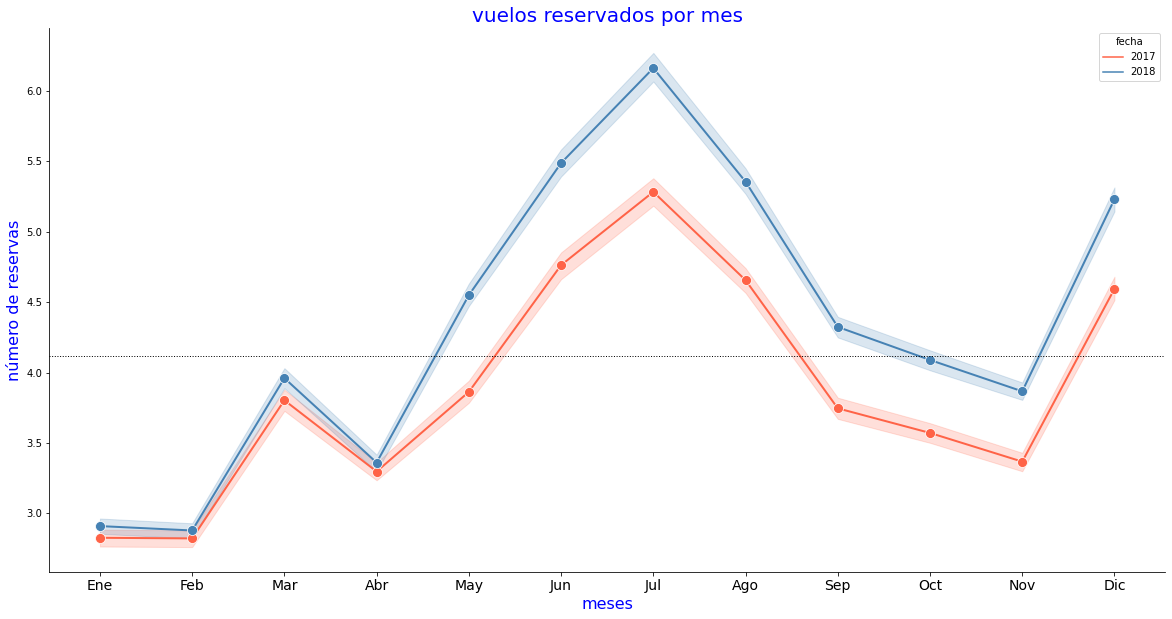

In [288]:
# hagamos un subplot con el vuelos_reservados y en función del mes
plt.subplots( figsize = (20, 10))

# Crear un gráfico de líneas que muestra la evolución de los vuelos reservados por mes, con una distinción por año
sns.lineplot(x=df1["fecha"].dt.month, # por mese
             y=df1["vuelos_reservados"],
            hue = df1["fecha"].dt.year, # variable ano
            palette = ["#FF6347", "#4682B4"], # color de las lineas            
            marker = "o", # para especificar que marcador queremos
            markersize = 10, # para establecer el tamaño del marcador
            linewidth = 2 # para cambiar el grosor de la linea
            )

# titulo
plt.title("vuelos reservados por mes",color = "blue", fontsize= 20)


# para cambiar las etiquetas del eje x y sus colores y tamaños
plt.xticks(np.sort(df1["fecha"].dt.month.unique()),  # valores originales del eje x
                ['Ene', "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], 
                color = "black", 
                fontsize = 14); # valores nuevos que queremos en el eje x

# para cambiar el nombre del eje x
plt.xlabel('meses', color = "blue",  fontsize = 16)

# para cambiar el nobre el eje y
plt.ylabel('número de reservas', color = "blue", fontsize = 16)

# para quitar los ejes de arriba y de la derecha       
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


# para añadir una linea fija en el plot en funcion de la media
media = df1["vuelos_reservados"].mean()
plt.axhline(media, color='black', linewidth=1, linestyle='dotted');


Suben las reservas en verano y navidad pero tambien vemos que el numero de reservas ha sido mayor en el 2018

## 2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes?

Text(0, 0.5, 'puntos acumulados')

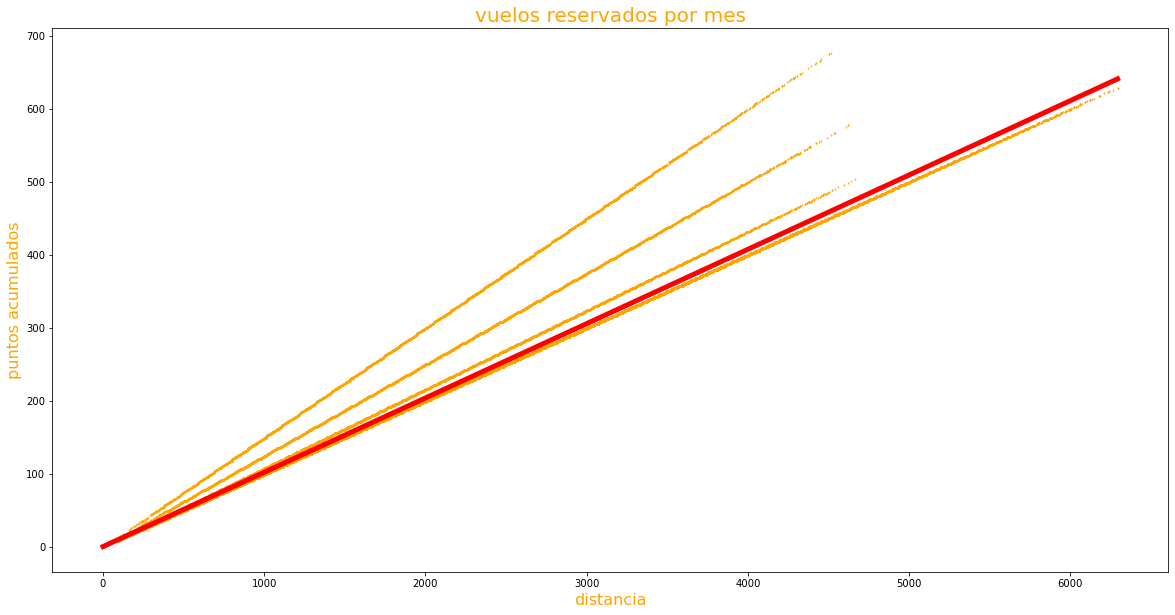

In [289]:
# tamaño de la grafica
plt.figure(figsize=(20, 10))
# Crear el gráfico de dispersión con una línea de regresión
sns.regplot(x = "distancia", 
            y = "puntos_acumulados", 
            data = df1, 
            marker = "d", # Especificar el marcador
            line_kws = {"color": "red", "linewidth": 5}, # cambiamos el color y el grosor de la linea de tendencia
            scatter_kws = {"color": "orange", "s": 1} # cambiamos el color y el tamaño de los puntos del scaterplot
            );
# titulo
plt.title("vuelos reservados por mes",color = "orange", fontsize= 20)

# para cambiar el nombre del eje x
plt.xlabel('distancia', color = "orange", fontsize = 16)

# para cambiar el nobre el eje y
plt.ylabel('puntos acumulados', color = "orange", fontsize = 16)

Vemos 4 lineas de tendencia, esto puede influir el tipo de tarjeta que tiene el cliente por lo que vamos hacer analisis con el df mergeado para ver la influencia en función de la tarjeta de lealtad

In [290]:
df['tarjeta_lealtad'].unique()

array(['Aurora', 'Nova', 'Star'], dtype=object)

Text(0, 0.5, 'puntos acumulados')

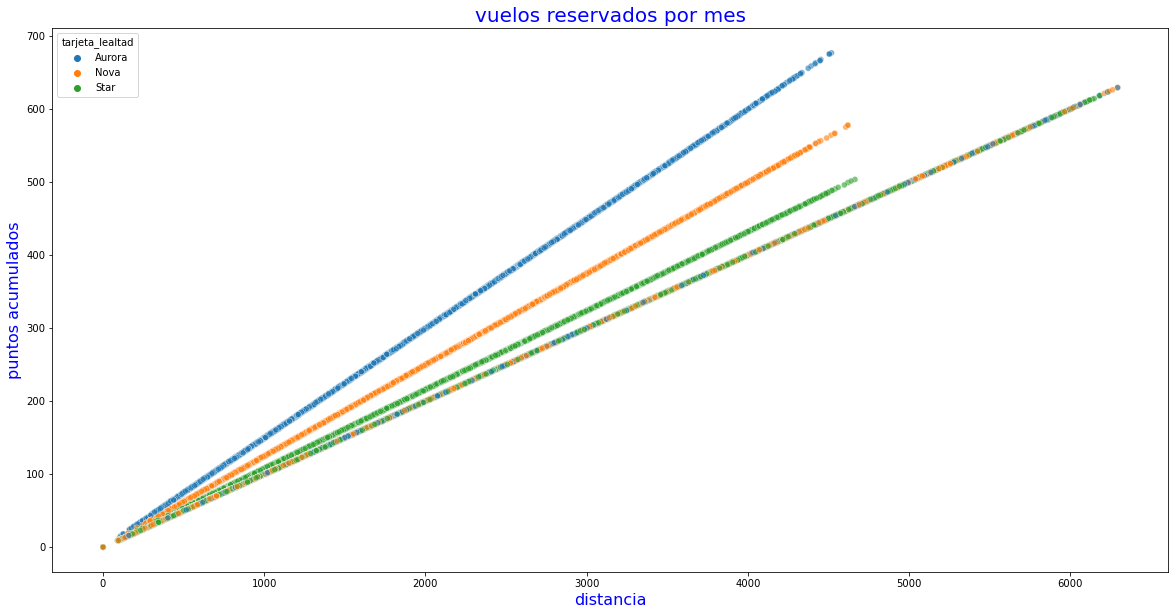

In [291]:
# tamaño de la grafica
plt.figure(figsize=(20, 10))

# Crear un gráfico de dispersión para visualizar la relación entre distancia y puntos acumulados
sns.scatterplot(x = "distancia", 
                y = "puntos_acumulados", 
                data = df,
                hue = "tarjeta_lealtad", # 
                alpha=0.6); # Ajusta la transparencia de los puntos
# titulo
plt.title("vuelos reservados por mes",color = "blue", fontsize= 20)

# para cambiar el nombre del eje x
plt.xlabel('distancia', color = "blue", fontsize = 16)

# para cambiar el nobre el eje y
plt.ylabel('puntos acumulados', color = "blue", fontsize = 16)

Vemos que hay una relacion entre la distancia y los puntos acumulados, esto se ve afectado por el tipo de tarjeta del cliente. Cuanto mas alto es tu tarjeta de lealtad mas acumilas

Habria que ver con mas detalle el motivo por el cual hay una cuarta linea, vamos a ver si corresponde a que el cliente no esta subscrito

In [292]:
df.columns

Index(['Unnamed: 0', 'numero_cliente', 'ano', 'mes', 'vuelos_reservados',
       'vuelos_con_acompanantes', 'total_vuelos', 'distancia',
       'puntos_acumulados', 'puntos_canjeados',
       'costo_en_dolares_de_los_puntos_canjeados', 'pais', 'provincia',
       'ciudad', 'codigo_postal', 'genero', 'educacion', 'salario',
       'estado_civil', 'tarjeta_lealtad', 'valoracion_cliente',
       'tipo_inscripcion', 'ano_inscripcion', 'mes_inscripcion',
       'ano_cancelacion', 'mes_cancelacion', 'estado_cliente'],
      dtype='object')

In [293]:
df['ano'] = df['ano']
df['mes'] = df['mes']
df['dia'] = 1

# Crear la columna de fecha combinando año, mes y día
df['fecha_vuelo'] = pd.to_datetime(df[['ano', 'mes', 'dia']].rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}))

# Verifica el resultado
print(df[['ano', 'mes', 'dia', 'fecha']].head())

KeyError: "['fecha'] not in index"

In [ ]:

df['dia_inscripcion'] = 1

# Crear la columna de fecha combinando año, mes y día
df['fecha_inscripcion'] = pd.to_datetime(df[['ano_inscripcion', 'mes_inscripcion', 'dia_inscripcion']].rename(columns={'ano_inscripcion': 'year', 'mes_inscripcion': 'month', 'dia_inscripcion': 'day'}))

# Verifica el resultado
print(df[['ano_inscripcion', 'mes_inscripcion', 'dia_inscripcion', 'fecha_inscripcion']].head())

   ano_inscripcion  mes_inscripcion  dia_inscripcion fecha_inscripcion
0             2016                8                1        2016-08-01
1             2013                3                1        2013-03-01
2             2016                7                1        2016-07-01
3             2015                8                1        2015-08-01
4             2014                1                1        2014-01-01


In [ ]:
df['dia_cancelacion'] = 1

# Crear la columna de fecha combinando año, mes y día
df['fecha_cancelacion'] = pd.to_datetime(df[['ano_cancelacion', 'mes_cancelacion', 'dia_cancelacion']].rename(columns={'ano_cancelacion': 'year', 'mes_cancelacion': 'month', 'dia_cancelacion': 'day'}))

# Verifica el resultado
print(df[['ano_cancelacion', 'mes_cancelacion', 'dia_cancelacion', 'fecha_cancelacion']].head())

   ano_cancelacion  mes_cancelacion  dia_cancelacion fecha_cancelacion
0             2099               12                1        2099-12-01
1             2099               12                1        2099-12-01
2             2099               12                1        2099-12-01
3             2099               12                1        2099-12-01
4             2099               12                1        2099-12-01


In [ ]:
df.columns

Index(['Unnamed: 0', 'numero_cliente', 'ano', 'mes', 'vuelos_reservados',
       'vuelos_con_acompanantes', 'total_vuelos', 'distancia',
       'puntos_acumulados', 'puntos_canjeados',
       'costo_en_dolares_de_los_puntos_canjeados', 'pais', 'provincia',
       'ciudad', 'codigo_postal', 'genero', 'educacion', 'salario',
       'estado_civil', 'tarjeta_lealtad', 'valoracion_cliente',
       'tipo_inscripcion', 'ano_inscripcion', 'mes_inscripcion',
       'ano_cancelacion', 'mes_cancelacion', 'estado_cliente', 'dia',
       'fecha_vuelo'],
      dtype='object')

In [ ]:
df_prueba = df.copy()

In [ ]:
# funcion para generar una nueva categoria en caso de que en el momento del vuelo tenga cancelada la tarjeta
def actualizar_tarjeta_lealtad (fecha_vuelo, fecha_inscripcion, fecha_cancelacion, tarjeta_lealtad):
    if fecha_inscripcion <= fecha_vuelo <= fecha_cancelacion:
        return tarjeta_lealtad
    else:
        return 'No Inscrito'

In [ ]:
# añadimos una nueva categoria a la tarjeta de lealtad
df['tarjeta_lealtad'] = df.apply(lambda fila: actualizar_tarjeta_lealtad(fila['fecha_vuelo'], fila['fecha_inscripcion'], fila['fecha_cancelacion'], fila['tarjeta_lealtad']),axis=1)

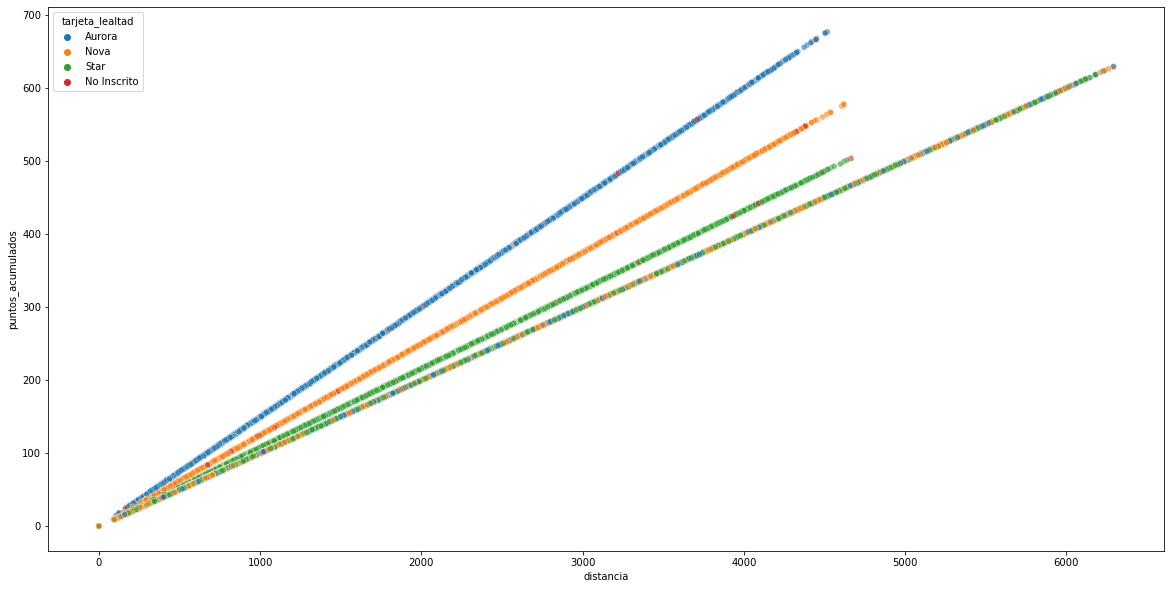

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = "distancia", 
                y = "puntos_acumulados", 
                data = df,
                hue = "tarjeta_lealtad",
                alpha=0.6); # Ajusta la transparencia de los puntos

Habría que seguir buscando pero se ve que hay una relación entre distancia y puntos

## 3. ¿Cuál es la distribución de los clientes por provincia o estado?

In [ ]:
df2["provincia"].value_counts()

Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: provincia, dtype: int64

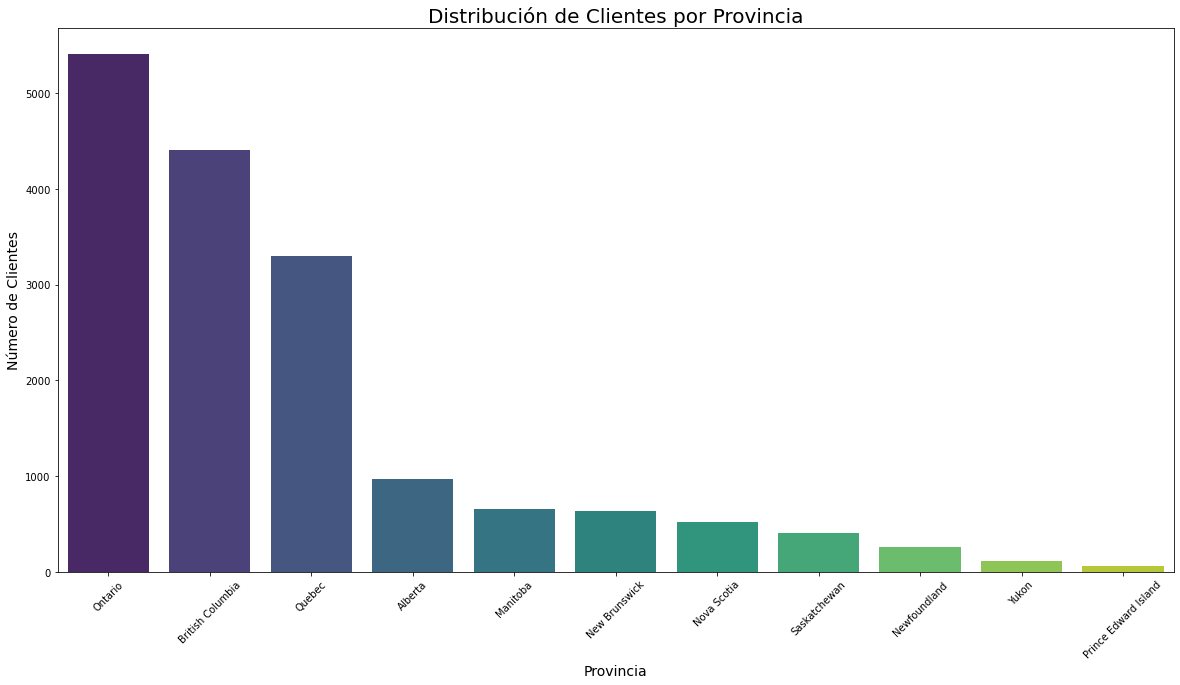

In [ ]:
# Ajustar el tamaño de la gráfica
plt.figure(figsize=(20, 10))


# Crear un gráfico de barras con los conteos de clientes por provincia
sns.countplot(x = "provincia", 
              data = df2,
              palette= "viridis",
              order = df2['provincia'].value_counts().index)

# Añadir un título y nombres de los ejes a la gráfica
plt.title('Distribución de Clientes por Provincia', fontsize=20)
plt.xlabel('Provincia', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
# rotamos los nombres
plt.xticks(rotation=45);

Todos nuestros clientes pertenecen a Canada por lo que la representación la hacemos sobre las provincias. La provincia con mas clientes es Ontario

## 4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

Usamos seaborn porque no es necesario calcular la media por nivel educativo

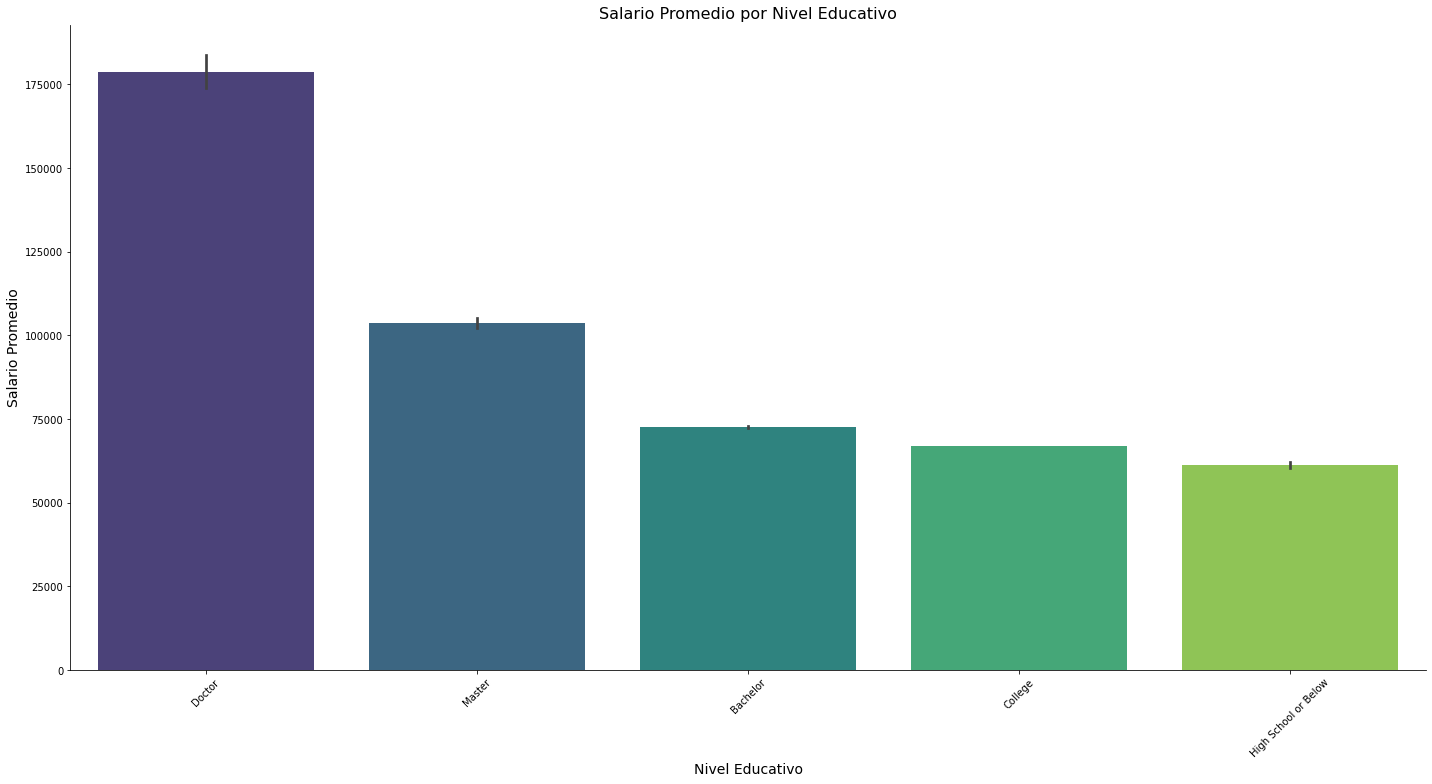

In [ ]:
# Tamaño de la gráfica
plt.figure(figsize=(20, 10))
# Crear el gráfico de barras para visualizar el salario promedio por nivel educativo
sns.barplot(x = "educacion",
            y = "salario", 
            data = df2,
            palette= "viridis",
            order = ["Doctor","Master", "Bachelor", "College", "High School or Below"]) # Ordenamos

# Configurar los títulos y etiquetas
plt.title('Salario Promedio por Nivel Educativo', fontsize=16)
plt.xlabel('Nivel Educativo', fontsize=14)
plt.ylabel('Salario Promedio', fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45)

# para quitar los ejes de arriba y de la derecha       
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

Podemos ver la barra con el intervalo de confianza. Que por defecto es del 95, en Collage no tenemos barra porque hemos introducido los valores ya que eran nan

vamos hacer lo mismo con Matplotlib

In [ ]:
# Calcula el salario promedio por nivel educativo y ordenamos
salario_promedio = df2.groupby('educacion')['salario'].mean().reset_index().sort_values(by='salario', ascending=False)

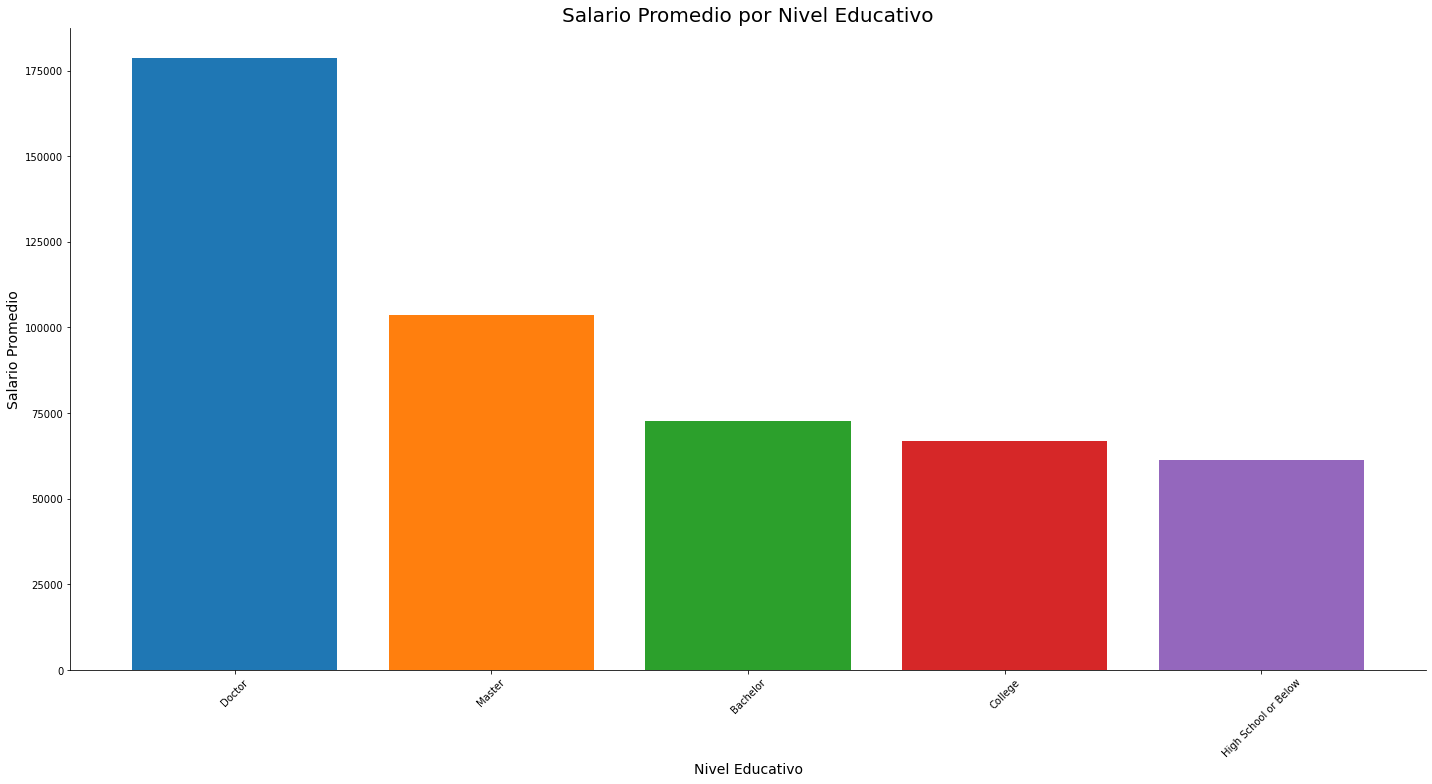

In [ ]:
# Tamaño de la gráfica
plt.figure(figsize=(20, 10))
# creamos un barplot usando Matplotlib, el método 'plt.bar()' 
plt.bar(x = "educacion", 
        height=  "salario", 
        data = salario_promedio,
        color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])        
# Configurar los títulos y etiquetas
plt.title('Salario Promedio por Nivel Educativo', fontsize=20)
plt.xlabel('Nivel Educativo', fontsize=14)
plt.ylabel('Salario Promedio', fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45)
# para quitar los ejes de arriba y de la derecha       
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

## 5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

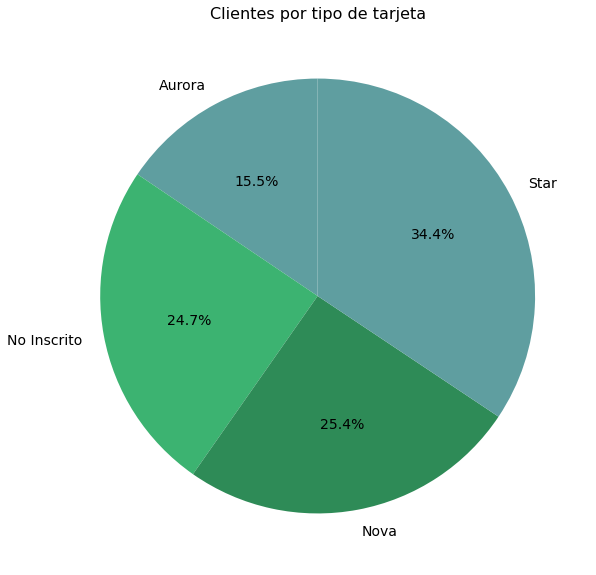

In [ ]:
# Agrupamos por tipo de tarjeta
df_tarjeta = df.groupby("tarjeta_lealtad")["numero_cliente"].count().reset_index()

plt.figure(figsize=(20, 10))
# lo primero que vamos a hacer es definir una lista para definir los colores que queremos para cada una de las categorías. 
# Esta lista debe tener tantos elementos como categorías tenemos en la columna de estudio (en este caso 7)
colores = ["cadetblue", "mediumseagreen", "seagreen"]

# creamos el gráfico basándonos en el DataFrame que hemos creado en el paso anterior
plt.pie("numero_cliente", 
        labels= "tarjeta_lealtad",
        data = df_tarjeta, 
        autopct=  '%1.1f%%', 
        colors = colores, 
        textprops={'fontsize': 14}, # Tamaño de la fuente para las etiquetas
        startangle=90);

# Configurar los títulos y etiquetas
plt.title('Clientes por tipo de tarjeta', fontsize=16);


La tarjeta mas demandada por los clientes es la Star

## 6. ¿Cómo se distribuyen los clientes según su estado civil y género?

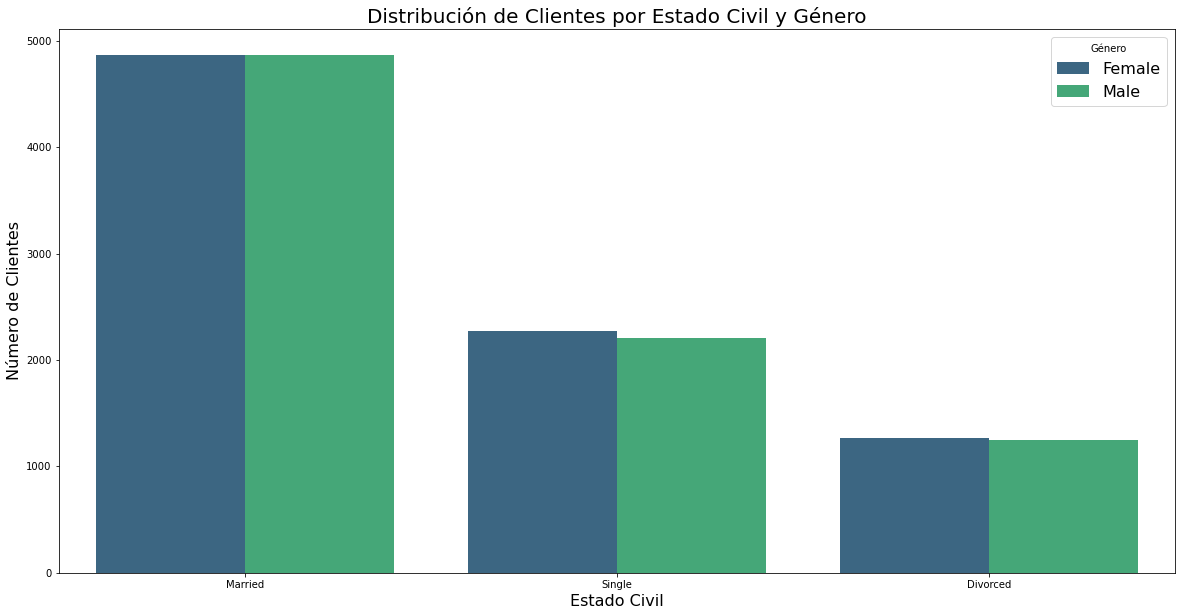

In [ ]:
# Crear el gráfico de barras apiladas
plt.figure(figsize=(20, 10))
sns.countplot(x='estado_civil', 
              hue='genero', 
              data=df2, 
              palette='viridis',
              order = ["Married", "Single", "Divorced"])
plt.title('Distribución de Clientes por Estado Civil y Género', fontsize=20)
plt.xlabel('Estado Civil', fontsize=16)
plt.ylabel('Número de Clientes', fontsize=16)
plt.legend(title='Género', fontsize=16);


Hay una proporción parecida entre nuestros clientes en función de su estado civil o genero